In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import galob
import time
import math
from PIL import Image
import skimage.io as io
from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
# %matplotlib inline
import seaborn as sns
sns.set_style('dark')
# %config Completer.use_jedi = False

## 測試資料範本
1. 翅膀內有淺色網格
    - 'GEO022_SJTT0612_1_male' 
2. 白色或透明翅膀(輪廓不明顯) - 配上加強邊緣對比的前處理
    - 'LYM09_SJTT0804_1_male', 'LYM11_SJTT0764_1_female', 'Not_id_yet_CARS1617', 'GEO014_SJTT0615_1_male', 'PYR10_SJTT0830_1_male'
3. 翅膀對比明顯，可能導致斑紋消失者
    - 'THY13_SJTT1849_1_female', 'NOT08_SJTT1001_1_male','THY13_SJTT0272_1_male','GEO022_SJTT1575_1_female'

## 參考資料
- [Comparison of segmentation and superpixel algorithms](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html)

In [11]:
dir = os.path.join('data', 'bk_lowcontrast')
# glob.glob('data/bk_lowcontrast/*')
files = glob.glob(dir + '/*')
file_names = [os.path.split(path)[-1]  for path in files]
file_names

['ARC02_SJTT0118_1_male_cropped.png',
 'ARC02_SJTT0121_1_male_cropped.png',
 'ARC02_SJTT0196_1_male_cropped.png',
 'ARC02_SJTT0199_1_male_cropped.png',
 'ARC02_SJTT0205_1_male_cropped.png',
 'ARC02_SJTT0544_1_male_cropped.png',
 'ARC02_SJTT0569_1_male_cropped.png',
 'ARC02_SJTT0570_1_male_cropped.png',
 'ARC02_SJTT0649_1_male_cropped.png',
 'ARC02_SJTT0655_1_male_cropped.png',
 'ARC02_SJTT1749_1_male_cropped.png',
 'ARC02_SJTT2491_1_male_cropped.png',
 'ARC03_SJTT2415_1_male_cropped.png',
 'ARC03_SJTT2449_1_male_cropped.png',
 'GEO0136_SJTT0138_1_male_cropped.png',
 'GEO0137_SJTT0254_1_male_cropped.png',
 'GEO026_CARS0015_cropped.png',
 'GEO026_CARS0106_cropped.png',
 'GEO035_CARS0003_cropped.png',
 'GEO035_CARS0450_cropped.png',
 'GEO036_CARS0141_cropped.png',
 'GEO036_CARS0273_cropped.png',
 'GEO036_CARS0642_cropped.png',
 'GEO050_CARS0035_cropped.png',
 'GEO052_CARS0453_cropped.png',
 'GEO057_CARS0325_cropped.png',
 'GEO058_CARS0430_cropped.png',
 'GEO058_CARS0448_cropped.png',
 'GE

In [20]:
files_pad = glob.glob('../crop/*_cropped256_padding255/*.png')
files_lowcon = [path for path in files_pad if os.path.split(path)[-1] in file_names] 

assert len(files_lowcon) == len(file_names)

save_dir = os.path.join('data', 'segmentation_padding255')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for idx, path in enumerate(files_lowcon):
    print(idx, path)
    img = io.imread(path)
    Img = Image.fromarray(img)
    Img.save(os.path.join(save_dir, f'{os.path.split(path)[-1]}'))

0 ../crop\CARS_cropped256_padding255\GEO026_CARS0015_cropped.png
1 ../crop\CARS_cropped256_padding255\GEO026_CARS0106_cropped.png
2 ../crop\CARS_cropped256_padding255\GEO035_CARS0003_cropped.png
3 ../crop\CARS_cropped256_padding255\GEO035_CARS0450_cropped.png
4 ../crop\CARS_cropped256_padding255\GEO036_CARS0141_cropped.png
5 ../crop\CARS_cropped256_padding255\GEO036_CARS0273_cropped.png
6 ../crop\CARS_cropped256_padding255\GEO036_CARS0642_cropped.png
7 ../crop\CARS_cropped256_padding255\GEO050_CARS0035_cropped.png
8 ../crop\CARS_cropped256_padding255\GEO052_CARS0453_cropped.png
9 ../crop\CARS_cropped256_padding255\GEO057_CARS0325_cropped.png
10 ../crop\CARS_cropped256_padding255\GEO058_CARS0430_cropped.png
11 ../crop\CARS_cropped256_padding255\GEO058_CARS0448_cropped.png
12 ../crop\CARS_cropped256_padding255\GEO058_CARS1936_cropped.png
13 ../crop\CARS_cropped256_padding255\GEO149_CARS1032_cropped.png
14 ../crop\CARS_cropped256_padding255\GEO149_CARS1033_cropped.png
15 ../crop\CARS_crop

..\crop\SJTT_cropped256_120up\GEO025_SJTT1539_1_female_cropped.png


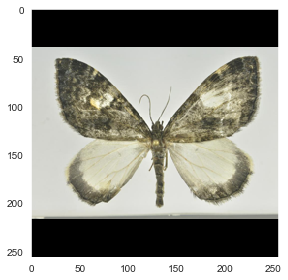

In [257]:
base_dir = os.path.join('..', 'crop', '**', '*')
files_ = glob.glob(base_dir + '.png', recursive=True)

img_name = 'GEO025_SJTT1539_1_female'  

path = [path for path in files_ if img_name in path][0]
print(path)
# img = img_as_float(astronaut()[::2, ::2])
img = io.imread(path)
io.imshow(img)
# Image.fromarray(img).show()

In [258]:
scales = [100, 500, 1000, 1500, 2000, 3000]
sigmas = [0.0, 0.1, 0.3, 0.4, 0.5]
min_size = 2000

segments_fz_boundaries = []

for sigma in sigmas:
    for scale in scales:
        segments_fz = felzenszwalb(
            img, scale=scale, sigma=sigma, min_size=min_size)
        segments_fz_boundaries.append(mark_boundaries(img, segments_fz))


In [259]:
compactnesses = [0.1, 0.25, 0.5, 0.75, 1, 10]
sigmas = [0.0 , 0.1, 0.3, 0.4, 0.5]
n_segments = 1000

segments_slic_boundaries = []

for sigma_slic in sigmas:
    for compactness in compactnesses:
        segments_slic = slic(img, n_segments=n_segments,
                             compactness=compactness, sigma=sigma_slic)
        segments_slic_boundaries.append(mark_boundaries(img, segments_slic))


In [260]:
def plot_segments(method='FEL'):
    '''
        method :　'FEL','SLIC'
    '''
    segments_boundaries = segments_slic_boundaries if method == 'SLIC' else segments_fz_boundaries
    para_segArea = 'compactness' if method == 'SLIC' else 'scale'

    rows = len(sigmas)
    segment = compactnesses if method == 'SLIC' else scales
    columns = len(segment)
    width = 4*columns
    height = math.ceil(width * rows/columns)

    fig, axes = plt.subplots(rows, columns,
                            figsize=(width, height), sharex=True, sharey=True)

    fig.suptitle(f'{method} segmentation', fontsize='24', y=0.95)

    idx=0
    for row, axes_ in enumerate(axes, 1):
        for col, ax in enumerate(axes_, 1):
            if row == 1:
                ax.set_title(
                    f'{para_segArea[:7]} : {segment[col-1]}', fontsize='14')
            if col == 1:
                ax.set_ylabel(f'sigma : {sigmas[row-1]}', fontsize='14')
            # ax.axis('off')
            ax.set_xticks([])
            ax.set_yticks([])
            # print('rows : ', row, 'columns : ', column )
            # idx = (row-1)*len(segment) + col-1
            
            ax.imshow(segments_boundaries[idx])
            idx+=1

    plt.subplots_adjust(wspace=0.01, hspace=0.02)

    save_dir = os.path.join('tmp', 'segmentation')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    file_name = f'{method}_{para_segArea}_{segment[0]}-{segment[-1]}_{img_name}.jpg'
    print(f'{file_name} saving...')
    fig.savefig(os.path.join(save_dir, file_name), bbox_inches='tight')
    plt.close(fig)


In [261]:
plot_segments(method='FEL')
plot_segments(method='SLIC')

FEL_scale_100-3000_GEO025_SJTT1539_1_female.jpg saving...
SLIC_compactness_0.1-10_GEO025_SJTT1539_1_female.jpg saving...


### NOTE: 參數設定
- sigma:輪廓平滑程度，數值越大越接近直線、數值越小切割的曲線越貼邊 
        - 'FEL': 0.5-1 上下有較好效果
        - 'FEL': 0.0-1 上下有較好效果
- 'FEL':　scale
        - Higher means larger clusters. 越大segment的網格越大
        - 500-100上下有較好效果
- 'SLIC' : compacrness
        - 平衡颜色接近性和空间接近性。较高的值会给空间接近性更多的权重
        - 10左右有較好效果
        - 100以上幾乎切分不出來， 0.1、1.會在標本主體切出比較大範圍的顏色區塊，但無法抓出翅膀輪廓

--------------------------------------------------------------------
- 針對淺色、與背景顏色相似輪廓不明顯的標本
        - 'FEL': siagma盡可能小(接近0.0)、scale500-1000-3000上下
        - 'SLIC':compactness在0.1-1、sigma在0.0-0.5間

- 針對有斑點的標本
        - 'FEL': sigma盡可能小(接近0.0)、scale500起跳
        - 'SLIC':compactness在10上下、sigma在0.0-0.5間(越小效果越好)

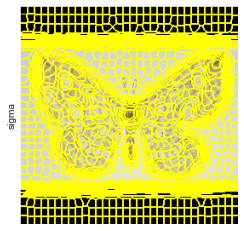

In [256]:
fig, ax = plt.subplots()
# ax.axis('off')
ax.set_xticks([]); ax.set_yticks([])
ax.set_ylabel('sigma')
ax.imshow(segments_boundaries[row*column-1])

Felzenszwalb number of segments: 1
SLIC number of segments: 939
Quickshift number of segments: 262


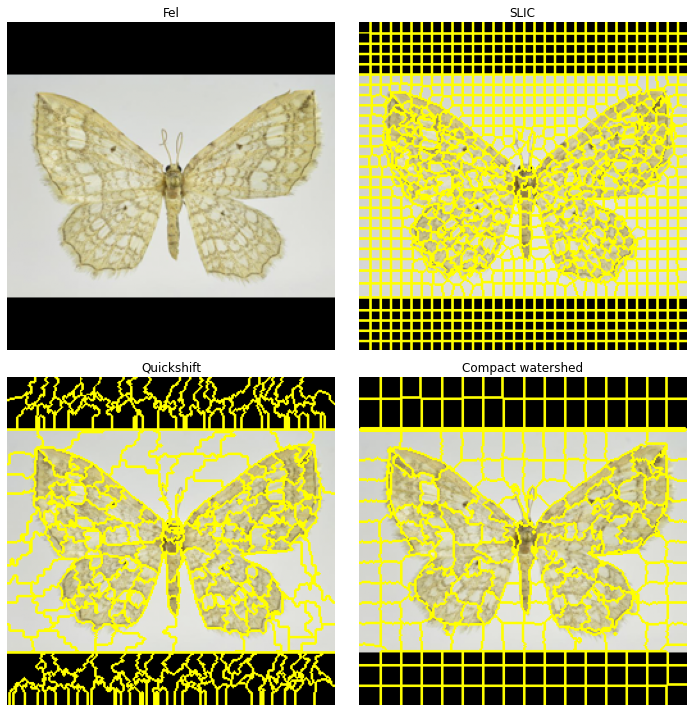

In [15]:
segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=20000)
segments_slic = slic(img, n_segments=1000, compactness=10, sigma=0)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print(f'Felzenszwalb number of segments: {len(np.unique(segments_fz))}')
print(f'SLIC number of segments: {len(np.unique(segments_slic))}')
print(f'Quickshift number of segments: {len(np.unique(segments_quick))}')

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Fel")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

save_dir = os.path.join('tmp', 'segmentation')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# plt.savefig(os.path.join(save_dir, 'segmentation.jpg'))